In [1]:
import os
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pandas.core.dtypes.common import is_numeric_dtype
from sklearn.feature_selection import mutual_info_regression, f_regression, SelectKBest
from sklearn.preprocessing import MinMaxScaler


In [2]:
DATA_FOLDER = 'dataset'
DATASET = os.path.join(DATA_FOLDER, 'outliers_removed.csv')

In [3]:
df = pd.read_csv(DATASET)

categorical_attr_list = [col for col in df.columns if not is_numeric_dtype(df[col])]

# one hot encoding
df_reg = df.drop(columns=categorical_attr_list)
df_reg = df_reg.join(pd.get_dummies(df[categorical_attr_list], columns=categorical_attr_list).astype(int))

df_reg.head()

,frame_count,sum,mean,std,min,max,q01,q05,q25,q75,...,actor_actor_24,actor_actor_3,actor_actor_4,actor_actor_5,actor_actor_6,actor_actor_7,actor_actor_8,actor_actor_9,sex_F,sex_M
0,158558,0.145081,9.150000e-07,0.004001,-0.038422,0.040588,-0.012586,-0.005890,-0.000031,0.0,...,0,0,0,0,0,0,0,0,0,1
1,160160,0.114319,7.137790e-07,0.004283,-0.042603,0.048157,-0.013550,-0.006104,-0.000031,0.0,...,0,0,0,0,0,0,0,0,0,1
2,156956,0.149963,9.554485e-07,0.005084,-0.037018,0.058472,-0.015822,-0.007294,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,1
3,152152,0.139618,9.176213e-07,0.004886,-0.036652,0.062683,-0.014923,-0.006714,-0.000031,0.0,...,0,0,0,0,0,0,0,0,0,1
4,169769,0.137665,8.108948e-07,0.002956,-0.026245,0.026215,-0.009399,-0.004364,-0.000031,0.0,...,0,0,0,0,0,0,0,0,0,1


# sc_min

## xgboost

In [4]:
TARGET = 'sc_min'

# drop quantile columns with high percentage of zeros (20%)
zero_percentage = (df_reg == 0).mean()
to_drop = [col for col in df_reg.columns if zero_percentage[col] > 0.2 and re.search(r'q\d{2}', col)]
df_reg = df_reg.drop(columns=to_drop)
to_drop

['mfcc_q50',
 'sc_q01',
 'sc_q05',
 'stft_q01',
 'stft_q05',
 'mfcc_q25_w1',
 'mfcc_q50_w1',
 'sc_q05_w1',
 'sc_q25_w1',
 'stft_q05_w1',
 'q50_w2',
 'q50_w3',
 'lag1_q50_w3',
 'q75_w4']

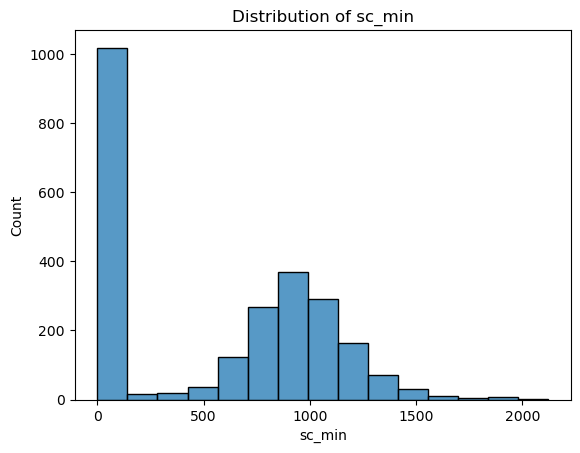

In [5]:
sns.histplot(data=df, x=df[TARGET])
plt.xlabel(f'{TARGET}')
plt.ylabel('Count')
plt.title(f'Distribution of {TARGET}')
plt.show()

In [6]:
from sklearn.model_selection import train_test_split

# rows to be fixed, do not reset indexes!
df_zero = df_reg[df_reg[TARGET] == 0]
df_nz = df_reg[df_reg[TARGET] != 0].reset_index(drop=True)

# dataframe has been one hot encoded
split_index = df_nz.index[df_nz['actor_actor_19'] == 1][0]

df_train = df_nz[:split_index]
df_test = df_nz[split_index:]

df_train, df_valid = train_test_split(df_train, test_size = 0.2, random_state = 100)

y_train = df_train[TARGET].to_numpy()
y_valid = df_valid[TARGET].to_numpy()
y_test = df_test[TARGET].to_numpy()

df_zero = df_zero.drop([TARGET], axis = 1)
df_train = df_train.drop([TARGET], axis = 1)
df_valid = df_valid.drop([TARGET], axis = 1)
df_test = df_test.drop([TARGET], axis = 1)

X_to_pred = df_zero.to_numpy()
X_train = df_train.to_numpy()
X_valid = df_valid.to_numpy()
X_test = df_test.to_numpy()

print(X_train.shape, X_valid.shape, X_test.shape, X_to_pred.shape)

(847, 270) (212, 270) (361, 270) (1009, 270)


C:\Users\emanu\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


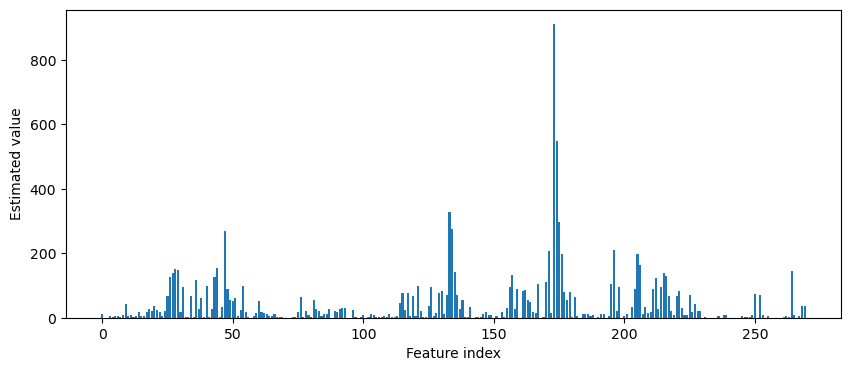

In [7]:
f_selector = SelectKBest(score_func = f_regression, k = 'all')
f_selector.fit(X_train, y_train)

plt.figure(figsize = (10, 4))
plt.bar([i for i in range(len(f_selector.scores_))], f_selector.scores_)
plt.xlabel('Feature index')
plt.ylabel('Estimated value')
plt.show()

In [8]:
f_selector = SelectKBest(score_func = f_regression, k = 10)
f_selector.fit(X_train, y_train)

X_train = f_selector.transform(X_train)
X_valid = f_selector.transform(X_valid)
X_test = f_selector.transform(X_test)
X_to_pred = f_selector.transform(X_to_pred)

# selected columns
selected_indices = f_selector.get_support(indices=True)
df_train.iloc[:, selected_indices]

C:\Users\emanu\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


,sc_q25,sc_q01_w2,sc_q05_w2,sc_mean_w3,sc_q01_w3,sc_q05_w3,sc_q25_w3,sc_q50_w3,zc_skew_w4,mfcc_q50_w4
259,1872.045102,1347.960576,1489.921327,1931.184503,1116.033592,1212.215438,1358.020500,1705.257250,3.595123,0.165307
157,2942.585558,1315.135357,1398.629908,2714.163426,823.486138,876.608240,1584.232512,2367.455035,2.865589,7.206193
667,1477.785981,705.138194,803.412355,1586.829664,937.444068,1053.909013,1259.824092,1496.566031,5.393879,3.266991
707,2616.879637,1186.732413,1546.434254,2361.227663,988.643551,1105.591378,1448.774492,1880.027363,2.177453,0.558810
125,3164.267715,1922.775674,2251.552376,2756.381107,1443.575892,1506.453749,2063.945834,2391.521167,2.568561,3.373528
...,...,...,...,...,...,...,...,...,...,...
802,1411.284120,1019.686715,1145.061661,1322.277562,893.476525,909.195392,980.743105,1278.848017,4.683931,3.313577
53,2216.479721,1536.245331,1762.329375,2479.108157,1465.527018,1518.101121,1829.542363,2254.740811,6.126823,6.565955
350,2020.566161,816.142082,985.926651,1979.083854,734.623135,875.756307,1500.137052,1712.007396,3.562200,6.325346
79,2962.181835,1481.238762,1942.911298,2912.952890,1296.712995,1412.026850,1994.622272,2565.782790,2.253350,-0.111700


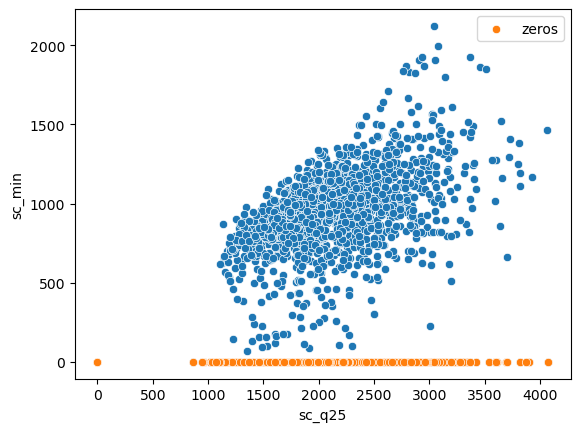

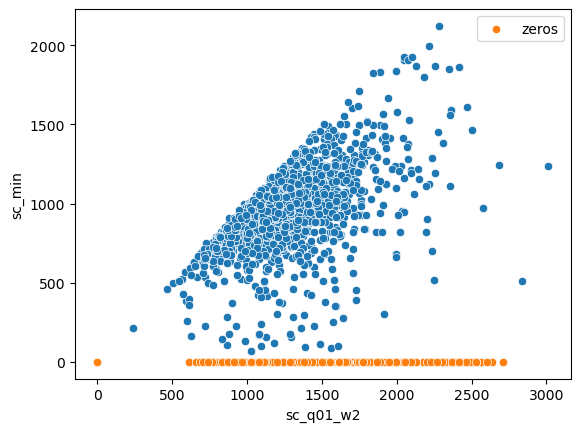

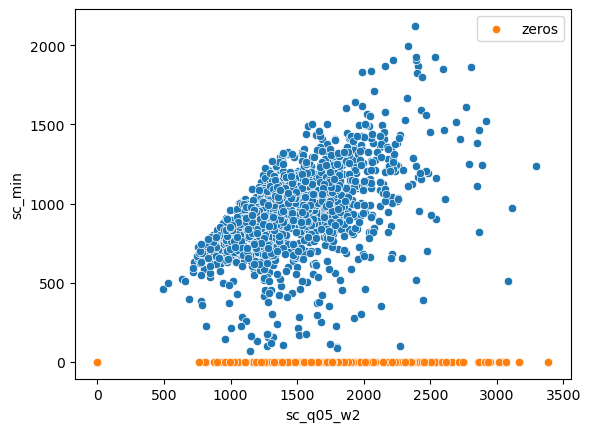

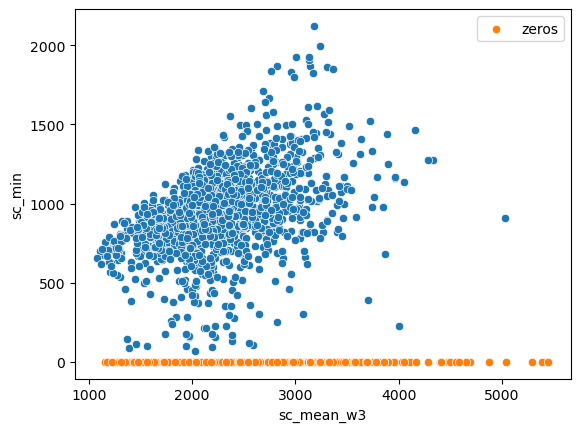

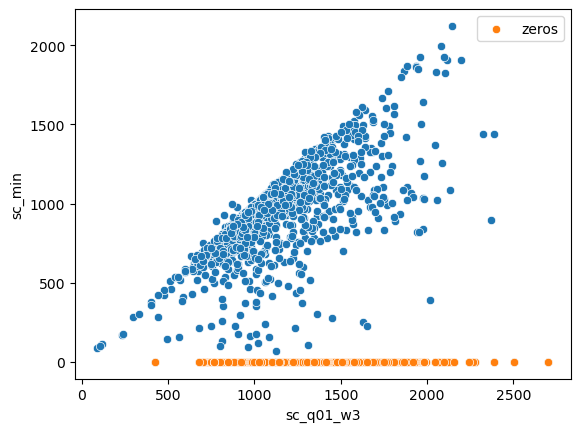

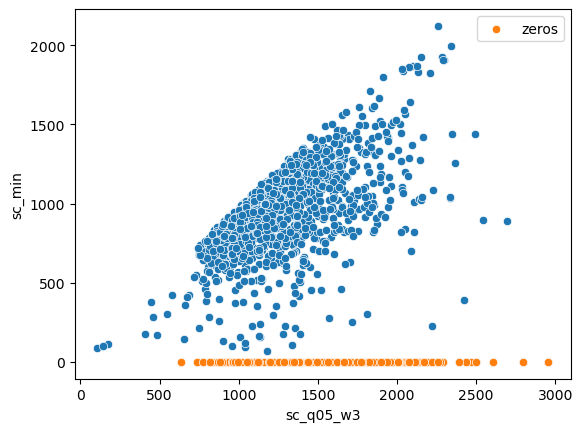

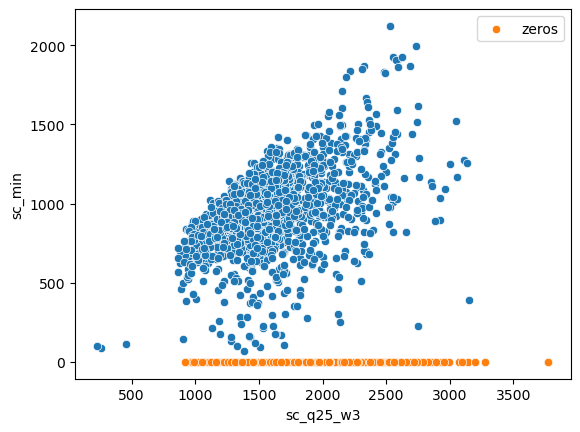

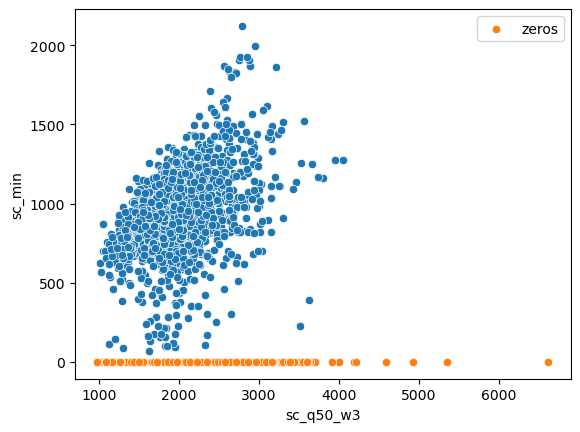

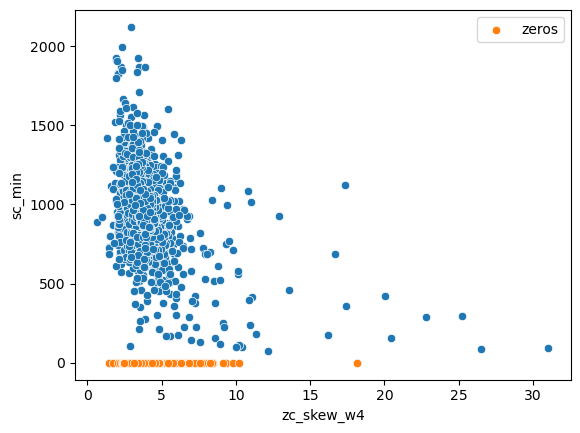

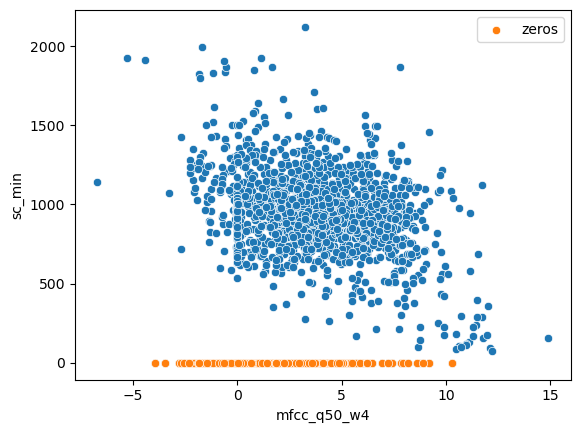

In [9]:
cols=list(df_train.iloc[:, selected_indices].columns)

for col in cols:
    sns.scatterplot(data = df_reg, y = TARGET, x = col)
    sns.scatterplot(data = df_reg[df_reg[TARGET] == 0], y = TARGET, x = col, label = 'zeros')
    plt.legend()
    plt.show()

In [10]:
#NB ha senso fare il minmaxscaler qui??
"""
scaler = MinMaxScaler()

y_train = scaler.fit_transform(y_train.reshape(-1, 1))
y_valid = scaler.fit_transform(y_valid.reshape(-1, 1))
y_test = scaler.fit_transform(y_test.reshape(-1, 1))

X_train = scaler.fit_transform(X_train)
X_valid = scaler.fit_transform(X_valid)
X_test = scaler.fit_transform(X_test)
X_to_pred = scaler.fit_transform(X_to_pred)"""

'\nscaler = MinMaxScaler()\n\ny_train = scaler.fit_transform(y_train.reshape(-1, 1))\ny_valid = scaler.fit_transform(y_valid.reshape(-1, 1))\ny_test = scaler.fit_transform(y_test.reshape(-1, 1))\n\nX_train = scaler.fit_transform(X_train)\nX_valid = scaler.fit_transform(X_valid)\nX_test = scaler.fit_transform(X_test)\nX_to_pred = scaler.fit_transform(X_to_pred)'

In [11]:
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import optuna

# objective function to be minimized
def objective_fun(trial):

    booster = trial.suggest_categorical('booster', ['gbtree', 'dart'])
    gamma = trial.suggest_float('gamma', 0.001,0.1)
    max_depth = trial.suggest_int('max_depth',3, 20)
    min_child_weight = trial.suggest_float('min_child_weight', 0, 2)
    subsample = trial.suggest_float('subsample', 0.4, 1)
#     eta =  trial.suggest_float('eta', 0.3, 1)

    xgb = XGBRegressor(booster=booster, gamma=gamma, max_depth=max_depth, min_child_weight=min_child_weight, subsample=subsample)

    xgb.fit(X_train, y_train)
    y_pred = xgb.predict(X_valid)

    error = mean_squared_error(y_valid, y_pred)

    return error


study = optuna.create_study()
study.optimize(objective_fun, n_trials = 150, n_jobs = -1)

[I 2023-06-08 10:53:46,232] A new study created in memory with name: no-name-1ff6ec7b-e224-4b38-81a5-92bb1425af49
[I 2023-06-08 10:53:47,395] Trial 0 finished with value: 20070.879455309114 and parameters: {'booster': 'gbtree', 'gamma': 0.05509528367328064, 'max_depth': 9, 'min_child_weight': 1.1720796196641534, 'subsample': 0.569721681497054}. Best is trial 0 with value: 20070.879455309114.
[I 2023-06-08 10:53:47,433] Trial 3 finished with value: 21122.46788753158 and parameters: {'booster': 'gbtree', 'gamma': 0.0820020740857557, 'max_depth': 10, 'min_child_weight': 1.051560754653009, 'subsample': 0.4732388097899283}. Best is trial 0 with value: 20070.879455309114.
[I 2023-06-08 10:53:48,208] Trial 6 finished with value: 24973.635067049778 and parameters: {'booster': 'gbtree', 'gamma': 0.0988498233497643, 'max_depth': 16, 'min_child_weight': 0.5135481245232525, 'subsample': 0.5349591291001807}. Best is trial 0 with value: 20070.879455309114.
[I 2023-06-08 10:53:48,287] Trial 2 finishe

[I 2023-06-08 10:53:53,217] Trial 31 finished with value: 20027.837315870962 and parameters: {'booster': 'gbtree', 'gamma': 0.08962925166713506, 'max_depth': 5, 'min_child_weight': 1.8731017463895359, 'subsample': 0.9192626538130756}. Best is trial 23 with value: 18744.037880163094.
[I 2023-06-08 10:53:53,780] Trial 32 finished with value: 19463.050947942913 and parameters: {'booster': 'gbtree', 'gamma': 0.08765249239210143, 'max_depth': 6, 'min_child_weight': 1.9863826547469001, 'subsample': 0.915907734562764}. Best is trial 23 with value: 18744.037880163094.
[I 2023-06-08 10:53:53,820] Trial 33 finished with value: 20504.354321790546 and parameters: {'booster': 'gbtree', 'gamma': 0.09026564695512043, 'max_depth': 6, 'min_child_weight': 1.9930903511785412, 'subsample': 0.8933534634461762}. Best is trial 23 with value: 18744.037880163094.
[I 2023-06-08 10:53:54,011] Trial 34 finished with value: 21337.340409107233 and parameters: {'booster': 'gbtree', 'gamma': 0.07175900807032132, 'max

[I 2023-06-08 10:53:59,949] Trial 56 finished with value: 23829.11890148896 and parameters: {'booster': 'dart', 'gamma': 0.07699368071142812, 'max_depth': 11, 'min_child_weight': 1.6169878827622204, 'subsample': 0.6704210005235731}. Best is trial 23 with value: 18744.037880163094.
[I 2023-06-08 10:54:00,237] Trial 57 finished with value: 21866.97000526116 and parameters: {'booster': 'dart', 'gamma': 0.0775070103631248, 'max_depth': 13, 'min_child_weight': 1.6881991443301048, 'subsample': 0.9244037752198163}. Best is trial 23 with value: 18744.037880163094.
[I 2023-06-08 10:54:01,026] Trial 61 finished with value: 21579.48142747125 and parameters: {'booster': 'dart', 'gamma': 0.07682898791182954, 'max_depth': 11, 'min_child_weight': 1.701532922127988, 'subsample': 0.9247614885703171}. Best is trial 23 with value: 18744.037880163094.
[I 2023-06-08 10:54:01,236] Trial 60 finished with value: 21270.775716168482 and parameters: {'booster': 'dart', 'gamma': 0.06587664938382355, 'max_depth': 

[I 2023-06-08 10:54:08,630] Trial 87 finished with value: 21089.72564410036 and parameters: {'booster': 'gbtree', 'gamma': 0.059563116274363094, 'max_depth': 17, 'min_child_weight': 1.545207039715962, 'subsample': 0.8418953654189916}. Best is trial 23 with value: 18744.037880163094.
[I 2023-06-08 10:54:09,125] Trial 88 finished with value: 19412.109859990145 and parameters: {'booster': 'gbtree', 'gamma': 0.0744467113136824, 'max_depth': 17, 'min_child_weight': 1.6501779085010138, 'subsample': 0.9389492804247358}. Best is trial 23 with value: 18744.037880163094.
[I 2023-06-08 10:54:09,623] Trial 89 finished with value: 20189.61340315075 and parameters: {'booster': 'gbtree', 'gamma': 0.07404751124359081, 'max_depth': 17, 'min_child_weight': 1.5701352227614445, 'subsample': 0.9334388163170855}. Best is trial 23 with value: 18744.037880163094.
[I 2023-06-08 10:54:09,721] Trial 96 finished with value: 17977.143146962117 and parameters: {'booster': 'gbtree', 'gamma': 0.07952740978769685, 'ma

[I 2023-06-08 10:54:14,863] Trial 115 finished with value: 18288.012080206787 and parameters: {'booster': 'dart', 'gamma': 0.07092590293295184, 'max_depth': 6, 'min_child_weight': 1.4185667199888194, 'subsample': 0.8195931850064443}. Best is trial 96 with value: 17977.143146962117.
[I 2023-06-08 10:54:15,076] Trial 119 finished with value: 18686.379944578264 and parameters: {'booster': 'dart', 'gamma': 0.07065526142345213, 'max_depth': 5, 'min_child_weight': 1.5019860071636206, 'subsample': 0.9671885571078779}. Best is trial 96 with value: 17977.143146962117.
[I 2023-06-08 10:54:15,159] Trial 117 finished with value: 18224.894292737783 and parameters: {'booster': 'dart', 'gamma': 0.07004642263517573, 'max_depth': 6, 'min_child_weight': 1.4010031283108282, 'subsample': 0.8196287087273483}. Best is trial 96 with value: 17977.143146962117.
[I 2023-06-08 10:54:15,160] Trial 118 finished with value: 21520.624046618857 and parameters: {'booster': 'dart', 'gamma': 0.07036762066818737, 'max_de

[I 2023-06-08 10:54:25,477] Trial 145 finished with value: 20859.409934110685 and parameters: {'booster': 'dart', 'gamma': 0.06843063150068616, 'max_depth': 12, 'min_child_weight': 1.4546807754952804, 'subsample': 0.9867286785822521}. Best is trial 96 with value: 17977.143146962117.
[I 2023-06-08 10:54:25,488] Trial 148 finished with value: 21054.1025011484 and parameters: {'booster': 'gbtree', 'gamma': 0.06794079110090034, 'max_depth': 12, 'min_child_weight': 1.5108506251065927, 'subsample': 0.8384935150897614}. Best is trial 96 with value: 17977.143146962117.
[I 2023-06-08 10:54:25,687] Trial 149 finished with value: 19507.27947686261 and parameters: {'booster': 'gbtree', 'gamma': 0.06696308127026664, 'max_depth': 12, 'min_child_weight': 1.5011906346691946, 'subsample': 0.8464616930751148}. Best is trial 96 with value: 17977.143146962117.
[I 2023-06-08 10:54:25,756] Trial 146 finished with value: 22056.36592399232 and parameters: {'booster': 'dart', 'gamma': 0.06919206239501562, 'max

In [12]:
best_params = study.best_params

xgb = XGBRegressor(**best_params)
xgb.fit(X_train, y_train)

y_pred_test = xgb.predict(X_test)

print(best_params)
print('Root mean squared error = %.4f' % np.sqrt(mean_squared_error(y_test, y_pred_test)))
print('R-squared = %.4f' % r2_score(y_test, y_pred_test))

{'booster': 'gbtree', 'gamma': 0.07952740978769685, 'max_depth': 4, 'min_child_weight': 1.4674914160863164, 'subsample': 0.8790825950177641}
Root mean squared error = 106.0616
R-squared = 0.7445


In [13]:
y_pred = xgb.predict(X_to_pred)
y_pred

array([ 851.05237,  804.4796 ,  864.7127 , ..., 1395.4567 , 1286.363  ,
       1355.8086 ], dtype=float32)

In [14]:
df_zero[TARGET] = y_pred
df.update(df_zero)

Text(0.5, 1.0, 'Distribution of predicted sc_min ')

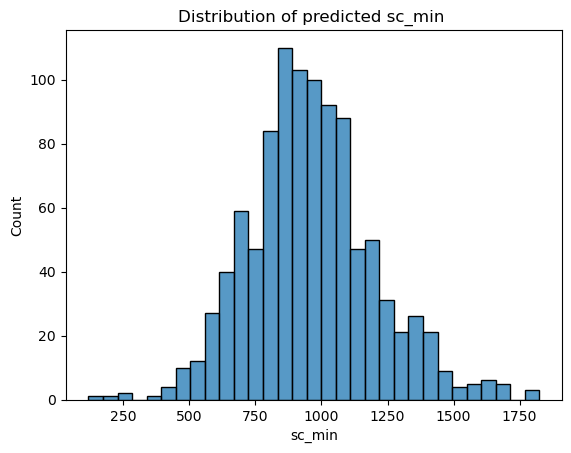

In [15]:
sns.histplot(data = df_zero, x = TARGET)
plt.title(f'Distribution of predicted {TARGET} ')

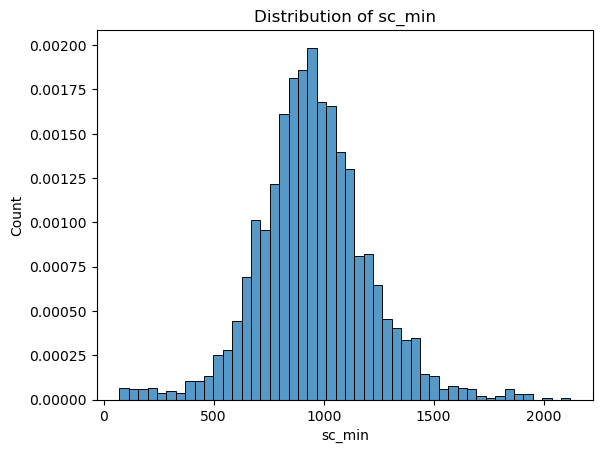

In [16]:
sns.histplot(data = df, x = TARGET, stat = 'density')
plt.xlabel(f'{TARGET}')
plt.ylabel('Count')
plt.title(f'Distribution of {TARGET}')
plt.show()

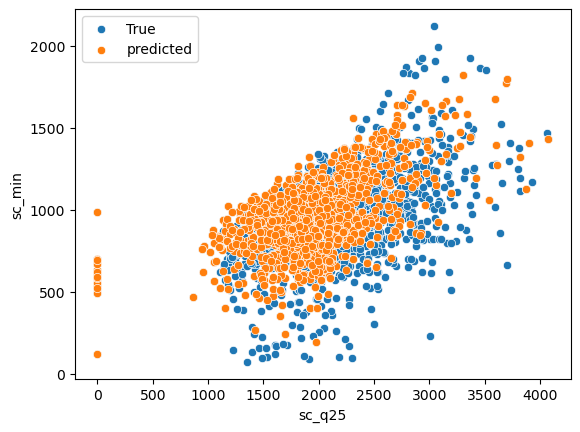

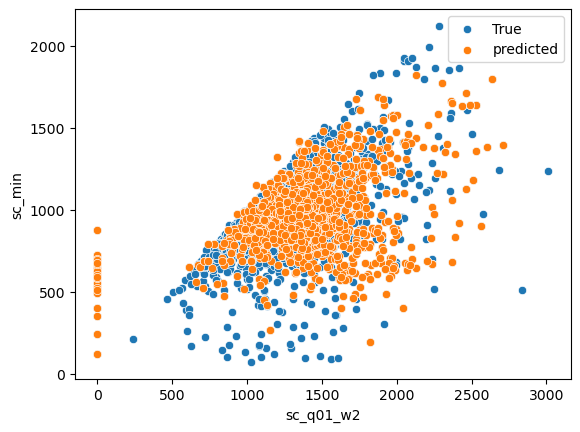

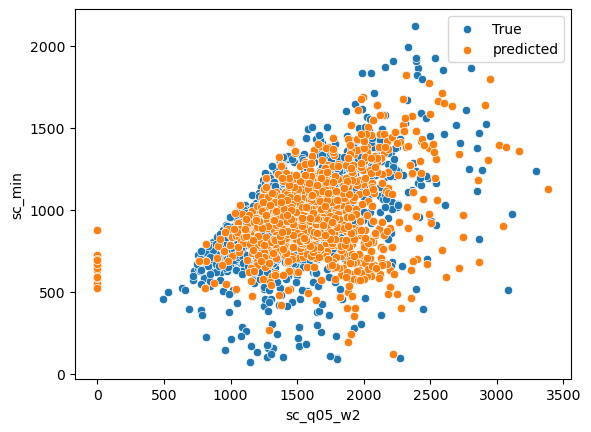

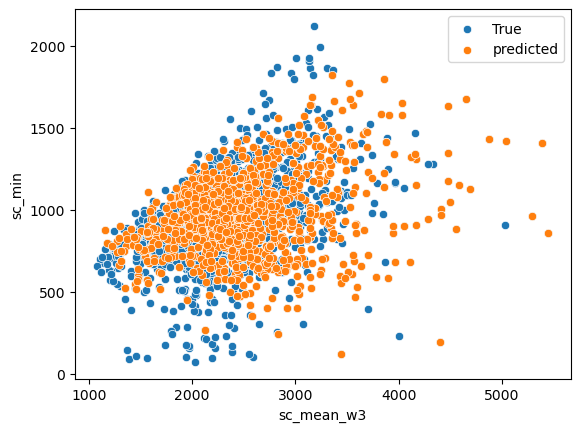

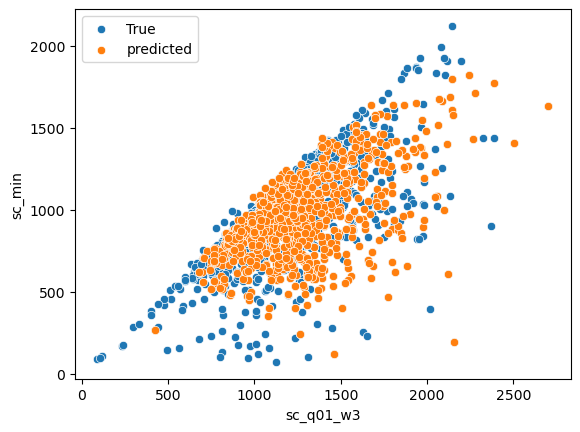

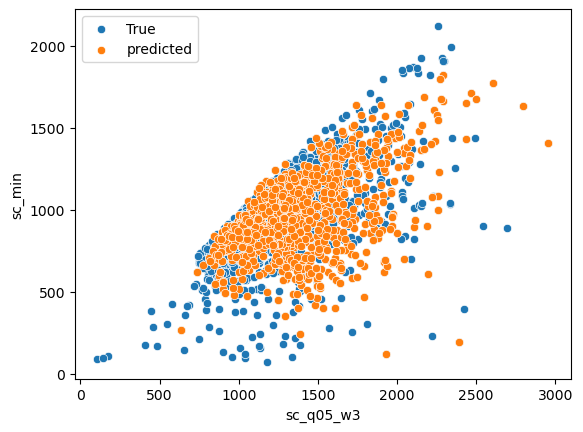

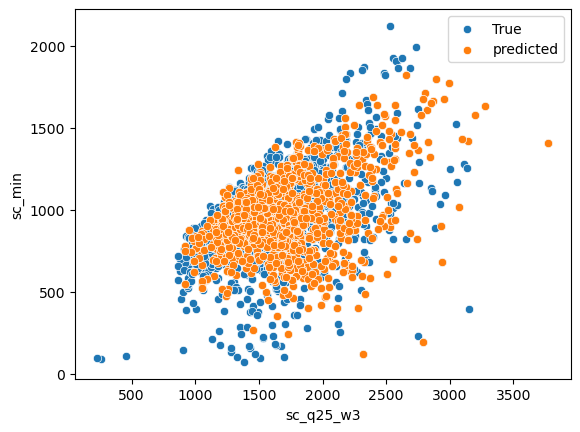

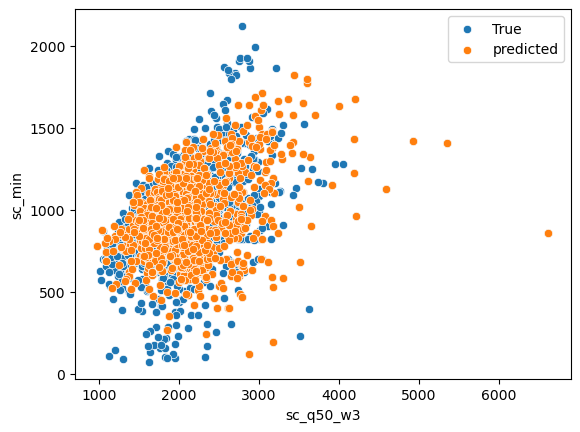

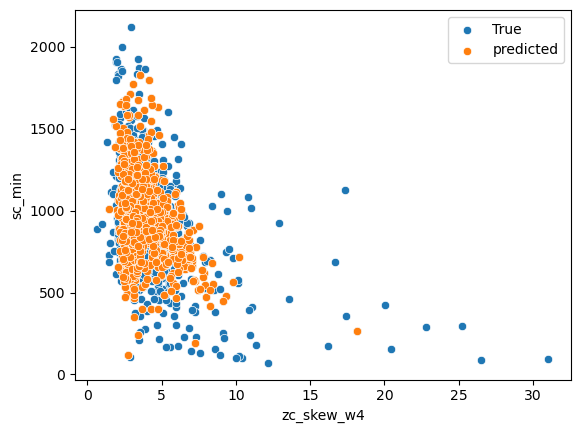

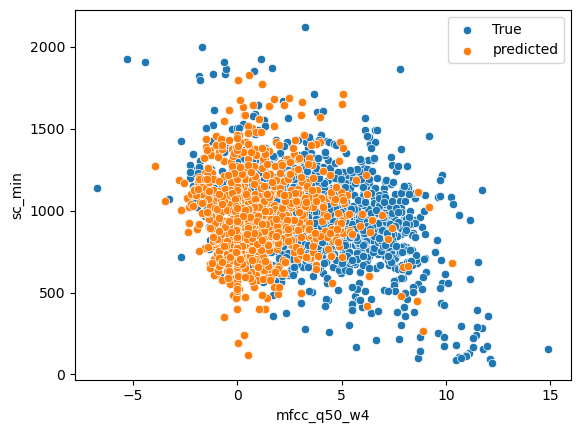

In [17]:
for col in cols:
    sns.scatterplot(data=df, y=TARGET, x=col, label='True')
    sns.scatterplot(data=df_zero,  y=y_pred, x=col, label='predicted')
    plt.legend()
    plt.show()

## random forest

In [19]:
from sklearn.ensemble import RandomForestRegressor

def objective_fun(trial):

    n_estimators = trial.suggest_int('n_estimators', 10,80)
    max_features = trial.suggest_categorical('max_features', ["auto", "sqrt", "log2"])
    min_samples_split = trial.suggest_int('min_samples_split', 3, 12)
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])

    
    regr = RandomForestRegressor(bootstrap=bootstrap ,min_samples_split=min_samples_split ,max_features=max_features ,n_estimators=n_estimators)

    regr.fit(X_train, y_train)
    y_pred = regr.predict(X_valid)

    error = mean_squared_error(y_valid, y_pred)

    return error


study = optuna.create_study()
study.optimize(objective_fun, n_trials = 150, n_jobs = -1)

[I 2023-06-08 11:23:50,093] A new study created in memory with name: no-name-ec9f3991-c307-4162-b0a2-c170be45ee32
[I 2023-06-08 11:23:50,526] Trial 5 finished with value: 21495.48822898157 and parameters: {'n_estimators': 16, 'max_features': 'log2', 'min_samples_split': 5, 'bootstrap': True}. Best is trial 5 with value: 21495.48822898157.
[I 2023-06-08 11:23:50,854] Trial 7 finished with value: 30215.055401995698 and parameters: {'n_estimators': 16, 'max_features': 'auto', 'min_samples_split': 5, 'bootstrap': False}. Best is trial 5 with value: 21495.48822898157.
[I 2023-06-08 11:23:51,031] Trial 6 finished with value: 19813.750909772556 and parameters: {'n_estimators': 52, 'max_features': 'log2', 'min_samples_split': 10, 'bootstrap': True}. Best is trial 6 with value: 19813.750909772556.
[I 2023-06-08 11:23:51,094] Trial 4 finished with value: 18879.54619806796 and parameters: {'n_estimators': 53, 'max_features': 'log2', 'min_samples_split': 5, 'bootstrap': True}. Best is trial 4 with

[I 2023-06-08 11:23:57,780] Trial 37 finished with value: 18690.317960921224 and parameters: {'n_estimators': 33, 'max_features': 'auto', 'min_samples_split': 12, 'bootstrap': True}. Best is trial 21 with value: 17935.03080181425.
[I 2023-06-08 11:23:57,975] Trial 35 finished with value: 19388.009147666173 and parameters: {'n_estimators': 71, 'max_features': 'auto', 'min_samples_split': 12, 'bootstrap': True}. Best is trial 21 with value: 17935.03080181425.
[I 2023-06-08 11:23:58,254] Trial 38 finished with value: 17933.824685368752 and parameters: {'n_estimators': 39, 'max_features': 'auto', 'min_samples_split': 10, 'bootstrap': True}. Best is trial 38 with value: 17933.824685368752.
[I 2023-06-08 11:23:58,690] Trial 39 finished with value: 18618.433094284323 and parameters: {'n_estimators': 59, 'max_features': 'auto', 'min_samples_split': 11, 'bootstrap': True}. Best is trial 38 with value: 17933.824685368752.
[I 2023-06-08 11:23:58,816] Trial 40 finished with value: 18099.1933097284

[I 2023-06-08 11:24:04,269] Trial 70 finished with value: 18650.442933062142 and parameters: {'n_estimators': 76, 'max_features': 'auto', 'min_samples_split': 8, 'bootstrap': True}. Best is trial 67 with value: 17673.41600257577.
[I 2023-06-08 11:24:04,306] Trial 71 finished with value: 17747.21706658788 and parameters: {'n_estimators': 76, 'max_features': 'auto', 'min_samples_split': 10, 'bootstrap': True}. Best is trial 67 with value: 17673.41600257577.
[I 2023-06-08 11:24:04,530] Trial 73 finished with value: 17977.020043680877 and parameters: {'n_estimators': 76, 'max_features': 'auto', 'min_samples_split': 10, 'bootstrap': True}. Best is trial 67 with value: 17673.41600257577.
[I 2023-06-08 11:24:04,692] Trial 72 finished with value: 18084.289028177405 and parameters: {'n_estimators': 76, 'max_features': 'auto', 'min_samples_split': 8, 'bootstrap': True}. Best is trial 67 with value: 17673.41600257577.
[I 2023-06-08 11:24:04,938] Trial 81 finished with value: 20410.308464676604 an

[I 2023-06-08 11:24:12,221] Trial 103 finished with value: 18676.75673287183 and parameters: {'n_estimators': 78, 'max_features': 'auto', 'min_samples_split': 12, 'bootstrap': True}. Best is trial 67 with value: 17673.41600257577.
[I 2023-06-08 11:24:12,459] Trial 108 finished with value: 19118.718876274434 and parameters: {'n_estimators': 69, 'max_features': 'auto', 'min_samples_split': 12, 'bootstrap': True}. Best is trial 67 with value: 17673.41600257577.
[I 2023-06-08 11:24:12,464] Trial 113 finished with value: 19415.708677242463 and parameters: {'n_estimators': 29, 'max_features': 'auto', 'min_samples_split': 9, 'bootstrap': True}. Best is trial 67 with value: 17673.41600257577.
[I 2023-06-08 11:24:12,467] Trial 105 finished with value: 18950.107888475224 and parameters: {'n_estimators': 78, 'max_features': 'auto', 'min_samples_split': 12, 'bootstrap': True}. Best is trial 67 with value: 17673.41600257577.
[I 2023-06-08 11:24:12,582] Trial 112 finished with value: 17533.601803348

[I 2023-06-08 11:24:18,711] Trial 142 finished with value: 18650.442809737822 and parameters: {'n_estimators': 71, 'max_features': 'auto', 'min_samples_split': 12, 'bootstrap': True}. Best is trial 112 with value: 17533.601803348174.
[I 2023-06-08 11:24:18,735] Trial 144 finished with value: 18686.53358630144 and parameters: {'n_estimators': 71, 'max_features': 'auto', 'min_samples_split': 12, 'bootstrap': True}. Best is trial 112 with value: 17533.601803348174.
[I 2023-06-08 11:24:18,799] Trial 147 finished with value: 18726.532597065307 and parameters: {'n_estimators': 38, 'max_features': 'sqrt', 'min_samples_split': 9, 'bootstrap': False}. Best is trial 112 with value: 17533.601803348174.
[I 2023-06-08 11:24:18,947] Trial 143 finished with value: 31749.362643183085 and parameters: {'n_estimators': 71, 'max_features': 'auto', 'min_samples_split': 12, 'bootstrap': False}. Best is trial 112 with value: 17533.601803348174.
[I 2023-06-08 11:24:19,080] Trial 149 finished with value: 19122

In [20]:
best_params = study.best_params

rf = RandomForestRegressor(**best_params)
rf.fit(X_train, y_train)

y_pred_test = rf.predict(X_test)

print(best_params)
print('Root mean squared error = %.4f' % np.sqrt(mean_squared_error(y_test, y_pred_test)))
print('R-squared = %.4f' % r2_score(y_test, y_pred_test))

{'n_estimators': 32, 'max_features': 'auto', 'min_samples_split': 12, 'bootstrap': True}
Root mean squared error = 118.0837
R-squared = 0.6833


In [21]:
y_pred = rf.predict(X_to_pred)
y_pred

array([ 855.34843281,  828.88314   ,  882.84208252, ..., 1390.03351441,
       1314.23866349, 1301.41716373])

In [22]:
df_zero[TARGET] = y_pred
df.update(df_zero)

Text(0.5, 1.0, 'Distribution of predicted sc_min ')

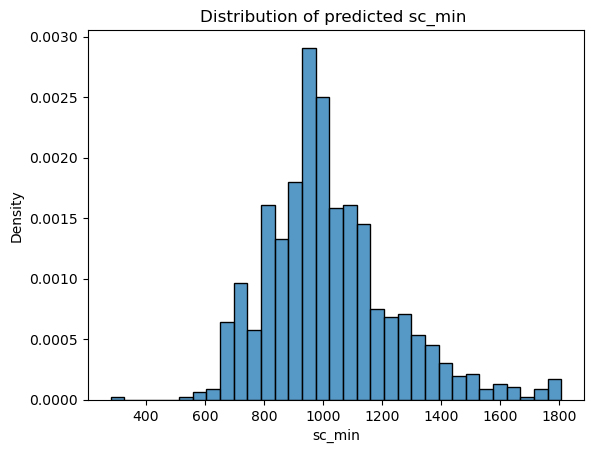

In [23]:
sns.histplot(data = df_zero, x = TARGET, stat = 'density')
plt.title(f'Distribution of predicted {TARGET} ')

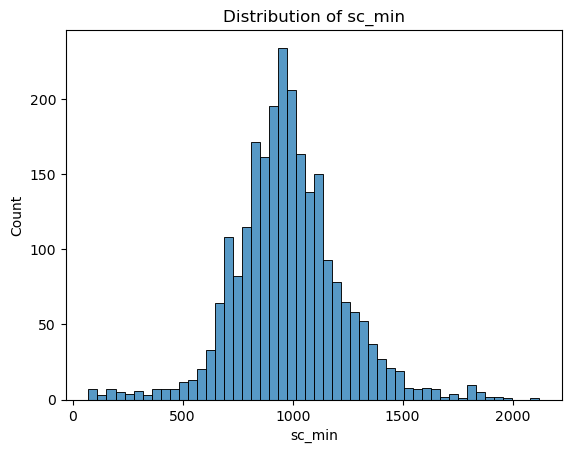

In [24]:
sns.histplot(data = df, x = TARGET)
plt.xlabel(TARGET)
plt.ylabel('Count')
plt.title(f'Distribution of {TARGET}')
plt.show()

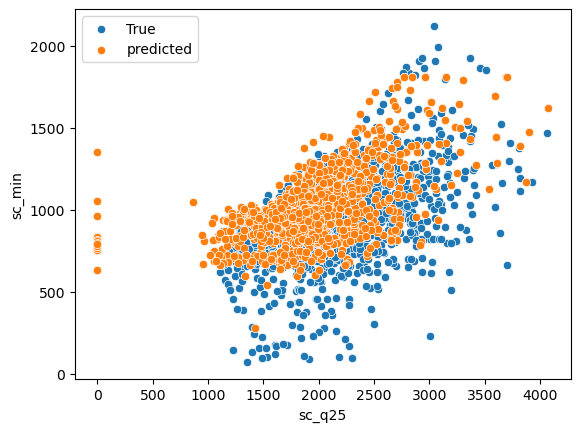

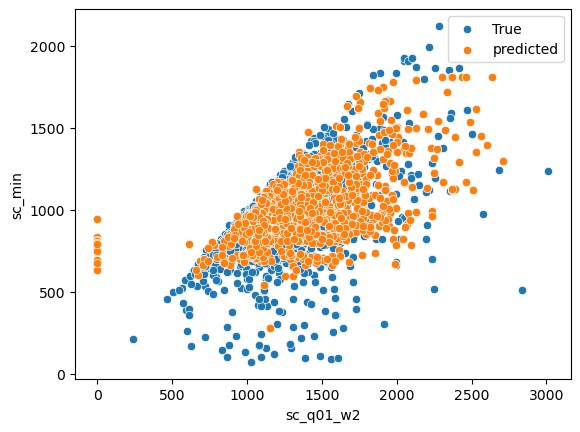

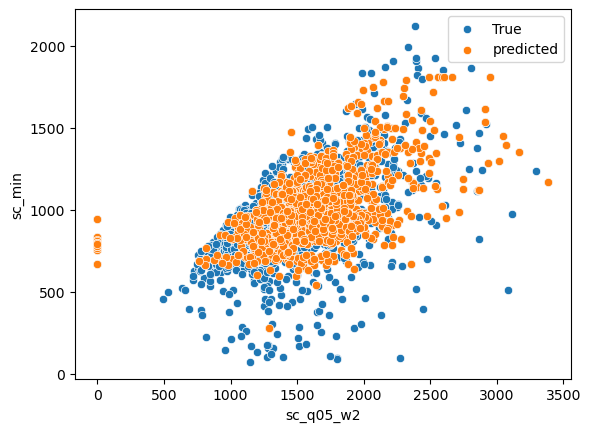

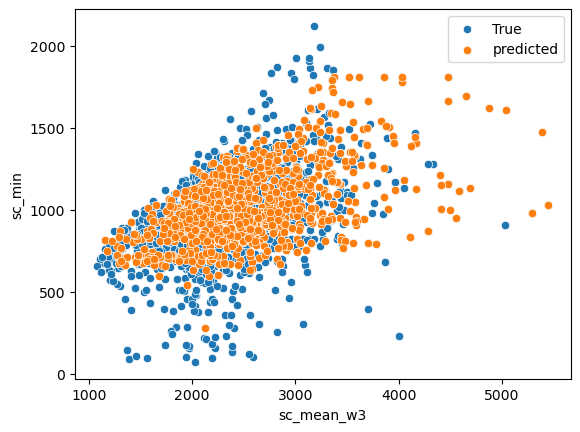

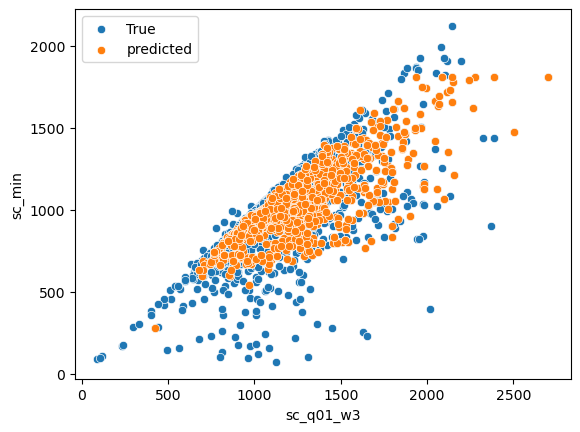

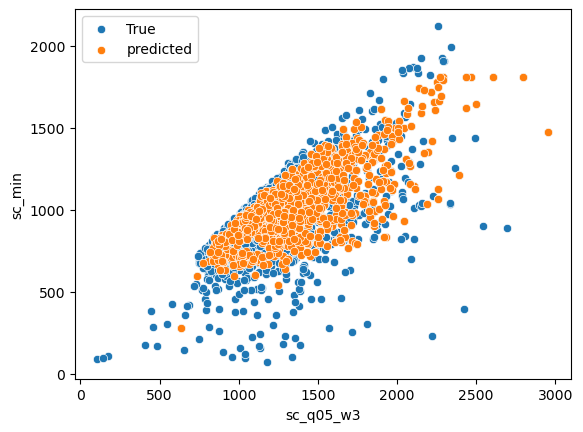

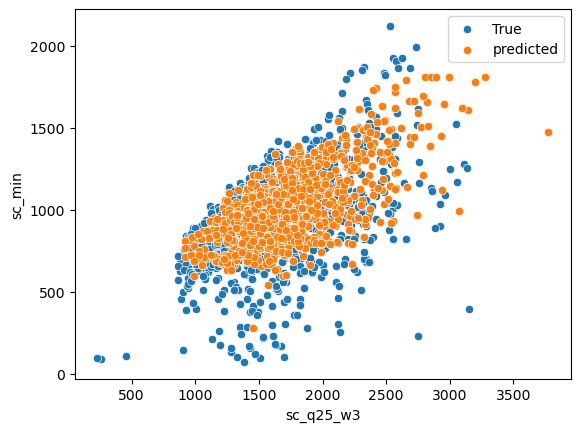

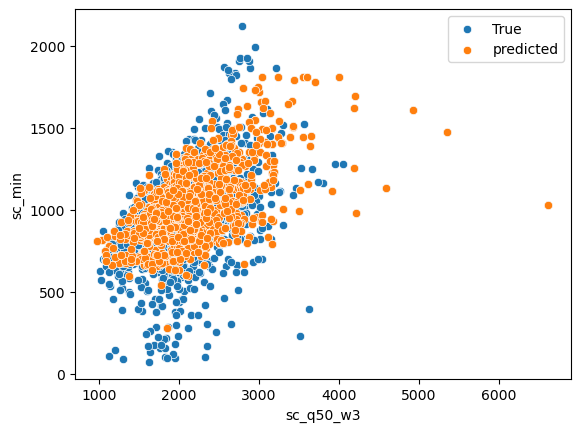

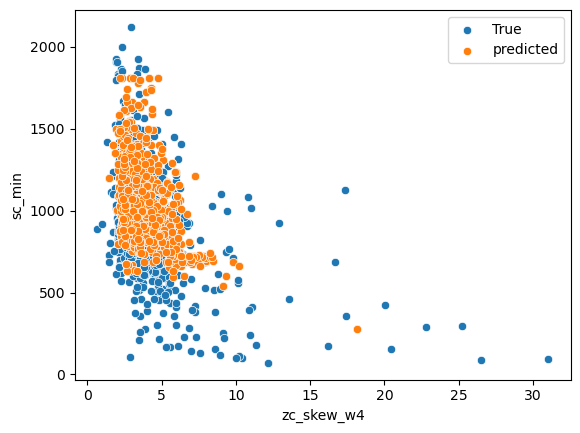

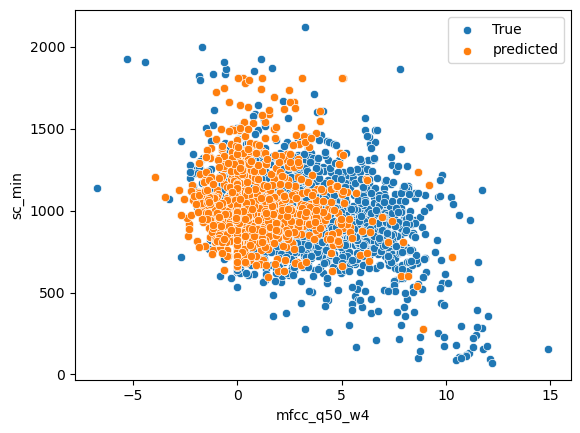

In [25]:
for col in cols:
    sns.scatterplot(data = df, y = TARGET, x = col, label = 'True')
    sns.scatterplot(data = df_zero,  y = y_pred, x = col, label = 'predicted')
    plt.legend()
    plt.show()